In [13]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

import pandas as pd
from tqdm import tqdm
import tempfile
import matplotlib.pyplot as plt
import plotly.express as px
import shutil
import os
import torch
import torch.nn.functional as F
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from cnn_models import TinyCNN, SimpleCNN, SimpleCNN_V2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loader Function

In [2]:
def get_client_dataloader(client_path, batch_size=32, val_split=0.2):
    is_pathological = "Pathological" in client_path
    temp_dir = None  # default

    if is_pathological:
        temp_dir = tempfile.TemporaryDirectory()
        temp_path = temp_dir.name

        for class_name in os.listdir(client_path):
            class_src = os.path.join(client_path, class_name)
            class_dst = os.path.join(temp_path, class_name)

            if os.path.isdir(class_src):
                valid_imgs = [f for f in os.listdir(class_src) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                if valid_imgs:
                    os.makedirs(class_dst, exist_ok=True)
                    for f in valid_imgs:
                        shutil.copy(os.path.join(class_src, f), os.path.join(class_dst, f))

        dataset_root = temp_path
    else:
        dataset_root = client_path

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    dataset = datasets.ImageFolder(root=dataset_root, transform=transform)
    val_size = int(val_split * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, temp_dir

In [3]:
split_root = "/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/splits"
model_dir = "/content/drive/MyDrive/Colab Notebooks/Covid19-dataset/best_models"
device = "cuda" if torch.cuda.is_available() else "cpu"

examples_to_run = []
all_split_types = sorted(os.listdir(split_root))

for split_type in tqdm(all_split_types, desc="Split Types"):
    split_path = os.path.join(split_root, split_type)
    if not os.path.isdir(split_path):
        continue

    clients = sorted(os.listdir(split_path))
    for client in tqdm(clients, desc=f"Clients in {split_type}", leave=False):
        model_files = [
            f for f in os.listdir(model_dir)
            if f.startswith(f"{split_type}_{client}") and f.endswith(".pth")
        ]
        if not model_files:
            continue

        model_file = model_files[0]
        model_path = os.path.join(model_dir, model_file)

        # Select the appropriate model class
        if "TinyCNN" in model_file:
            model = TinyCNN(num_classes=3)
        elif "SimpleCNN_V2" in model_file:
            model = SimpleCNN_V2(num_classes=3)
        else:
            model = SimpleCNN(num_classes=3)

        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)

        client_path = os.path.join(split_path, client)
        train_loader, val_loader, temp_dir = get_client_dataloader(client_path)
        class_names = val_loader.dataset.dataset.classes

        examples_to_run.append((model, val_loader, class_names, temp_dir, split_type, client))

Split Types: 100%|██████████| 7/7 [01:16<00:00, 10.86s/it]


# Prediction Printer

In [4]:
def show_sample_predictions(model, val_loader, class_names, client_entry, split_type_entry, num_samples=6, device='cpu'):
    """
    Displays a few sample images from the validation set along with predicted and true labels.
    """

    print(f"Sample Predictions for {client_entry} in {split_type_entry}\n")
    model.eval()
    shown = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(images)):
                if shown >= num_samples:
                    return

                # Setup subplot grid: 2 columns
                if shown % 2 == 0:
                    fig, axs = plt.subplots(1, 2, figsize=(8, 5))  # 2 images per row

                col = shown % 2
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5) + 0.5  # reverse normalization

                axs[col].imshow(img)
                axs[col].set_title(
                    f"True: {class_names[labels[i].item()]}\nPred: {class_names[preds[i].item()]}"
                )
                axs[col].axis('off')

                shown += 1

                if shown % 2 == 0 or shown == num_samples:
                    plt.tight_layout()
                    plt.show()

# Confusion Matrix

In [5]:
def plot_confusion_matrix(model, val_loader, class_names, client_entry, split_type_entry, device='cpu'):
    """
    Plots a confusion matrix for the model's predictions on the validation set.
    """

    print(f"\n\nConfusion Matrix for {client_entry} in {split_type_entry}\n")
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# Visualizes Predictions and Confusion Matrix

Visualizing Client-1 in Quantity_skew...


Sample Predictions for Client-1 in Quantity_skew



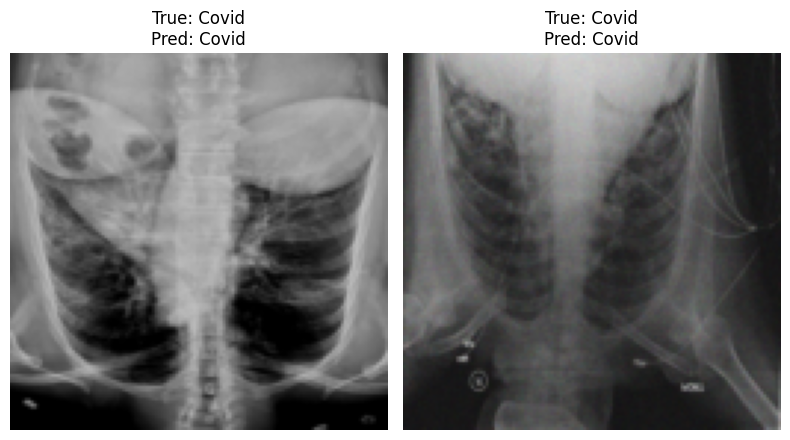

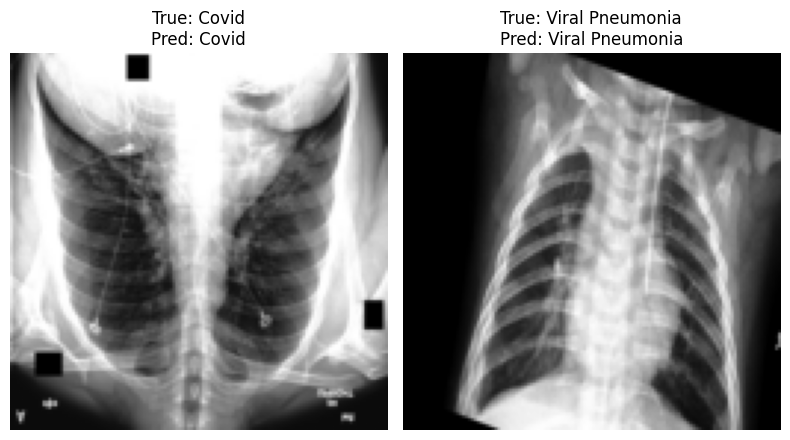

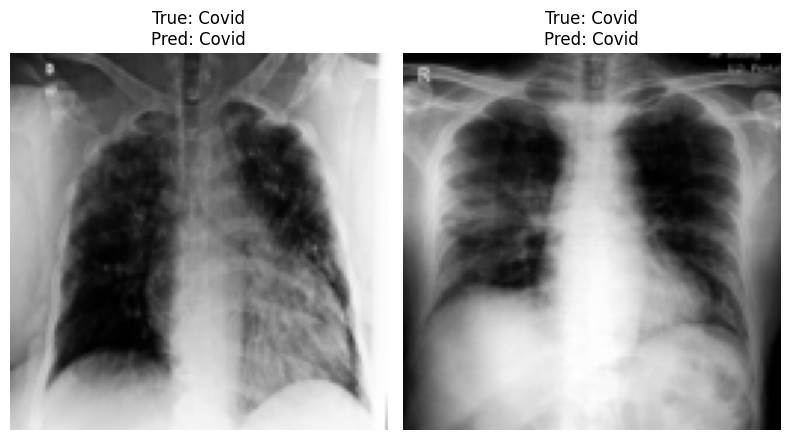



Confusion Matrix for Client-1 in Quantity_skew



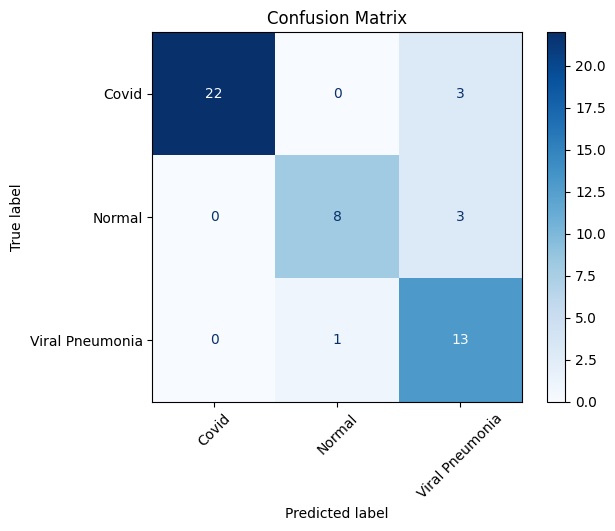

In [6]:
def visualize_client_result(split_type, client_name, examples_to_run, device='cuda'):
    """
    Visualizes predictions and confusion matrix for a specific client from examples_to_run.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    found = False
    for entry in examples_to_run:
        model, val_loader, class_names, temp_dir, split_type_entry, client_entry = entry
        if split_type_entry == split_type and client_entry == client_name:
            print(f"Visualizing {client_entry} in {split_type_entry}...\n\n")

            model.to(device)
            show_sample_predictions(model, val_loader, class_names, client_entry, split_type_entry, device=device)
            plot_confusion_matrix(model, val_loader, class_names, client_entry, split_type_entry, device=device)

            if temp_dir is not None:
                temp_dir.cleanup()

            found = True
            break

    if not found:
        print(f"No match found for Client: {client_name} in Split: {split_type}")

visualize_client_result("Quantity_skew", "Client-1", examples_to_run)

In [7]:
def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    correct, total, loss_total = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            loss_total += loss.item() * labels.size(0)
            total += labels.size(0)
    return correct / total, loss_total / total

In [8]:
results = []
for model, val_loader, class_names, temp_dir, split_type, client in tqdm(examples_to_run, desc="Evaluating Clients"):

    model.to(device)

    client_path = os.path.join(split_root, split_type, client)
    train_loader, _, _ = get_client_dataloader(client_path, batch_size=64)

    train_acc, train_loss = evaluate_model(model, train_loader, device=device)
    val_acc, val_loss = evaluate_model(model, val_loader, device=device)

    results.append({
        "Split": split_type,
        "Client": client,
        "Train Acc": train_acc,
        "Val Acc": val_acc,
        "Train Loss": train_loss,
        "Val Loss": val_loss
    })

Evaluating Clients: 100%|██████████| 21/21 [24:00<00:00, 68.58s/it]


In [10]:
df = pd.DataFrame(results)

df

,Split,Client,Train Acc,Val Acc,Train Loss,Val Loss
0,Concept_shift,Client-1,0.962687,0.960000,0.144910,0.181027
1,Concept_shift,Client-2,0.975124,0.980000,0.106076,0.117361
2,Concept_shift,Client-3,0.922886,0.970000,0.233131,0.141716
3,Dirichlet_label,Client-1,0.948718,0.973684,0.213877,0.158977
4,Dirichlet_label,Client-2,0.914474,0.911504,0.231868,0.230879
5,Dirichlet_label,Client-3,0.974790,0.986486,0.080122,0.061213
6,Feature_skew,Client-1,0.962687,0.970000,0.131825,0.162367
7,Feature_skew,Client-2,0.960199,0.950000,0.174648,0.175610
8,Feature_skew,Client-3,0.955224,0.940000,0.159766,0.172726
9,IID_equal,Client-1,0.947761,0.930000,0.171087,0.302398


In [11]:
save_dir = "/content/drive/MyDrive/Colab Notebooks/eval_reports"
os.makedirs(save_dir, exist_ok=True)

# Save file
csv_path = os.path.join(save_dir, "train_val_accuracy_loss.csv")
df.to_csv(csv_path, index=False)

print(f"DataFrame saved to: {csv_path}")

DataFrame saved to: /content/drive/MyDrive/Colab Notebooks/eval_reports/train_val_accuracy_loss.csv


In [18]:
# Line Plot: Train vs Validation Accuracy
df_long_acc = df.melt(id_vars=["Split", "Client"], value_vars=["Train Acc", "Val Acc"],
                      var_name="Metric", value_name="Accuracy")

# Line plot per split type
fig = px.line(
    df_long_acc,
    x="Client",
    y="Accuracy",
    color="Metric",
    facet_col="Split",
    facet_col_wrap=4,  # You can adjust this to control layout
    markers=True,
    title="Train vs Validation Accuracy per Client (Grouped by Split Type)"
)

fig.update_layout(template="plotly_white")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))  # clean facet titles
fig.show()

In [19]:
# Line Plot: Train vs Validation Loss
df_long_loss = df.melt(id_vars=["Split", "Client"], value_vars=["Train Loss", "Val Loss"],
                      var_name="Metric", value_name="Loss")

# Line plot per split type
fig = px.line(
    df_long_loss,
    x="Client",
    y="Loss",
    color="Metric",
    facet_col="Split",
    facet_col_wrap=4,  # You can adjust this to control layout
    markers=True,
    title="Train vs Validation Loss per Client (Grouped by Split Type)"
)

fig.update_layout(template="plotly_white")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))  # clean facet titles
fig.show()